# Ensemble Learning

In this notebook file, Ensemble Learning method will be used with FabricWaste data for predict SecondQualityRate

In [1]:
#Libraries are being imported
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlibVersion

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import __version__ as sklearnVersion

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.metrics import MAE
from tensorflow.keras.callbacks import Callback
from tensorflow import __version__ as tensorflowVersion

from joblib import load, __version__ as joblibVersion

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('matplotlib Version: ' + matplotlibVersion)
print('sklearn Version: ' + sklearnVersion)
print('tensorflow Version: ' + tensorflowVersion)
print('joblib Version: ' + joblibVersion)

numpy Version: 1.23.5
pandas Version: 1.5.2
matplotlib Version: 3.6.2
sklearn Version: 1.2.0
tensorflow Version: 2.10.0
joblib Version: 1.1.1


In [3]:
#Constant is being defined
MODEL_NAME = 'Ensemble Learning'

In [4]:
#Class that defines the regression models to use, and model result information
class RegressionModel:
    def __init__(self, name, model, weight, needAdjust):
        self.name = name
        self.model = model
        self.weight = weight
        self.needAdjust = needAdjust

In [5]:
#The class to use for predicting with the Ensemble Learning method
class EnsemblePredictor:
    def __init__(self, regressorList):
        #list of regression models to use
        self.regressorList = regressorList

    #Method to make predictions
    def predict(self, dataX):
        
        result = np.zeros(dataX.shape[0])
        #For each model
        for regressor in self.regressorList:
            
            #results are being predicted
            predict = regressor.model.predict(dataX).reshape(-1)
            
            #results are being adjusted if it is needed
            if regressor.needAdjust:
                predict[predict < 0] = 0
                predict[predict > 8] = 8
            
            #the predictions are being multiplied by the weight value of the model and added to the result array
            #each model will have a weight between 0 and 1
            #this process applies Weighted Averaging Method for Ensemble Learning
            result += predict * regressor.weight

        return result

In [6]:
#resultFrame is being created by reading pkl files
resultFrame = pd.concat([pd.read_pickle('../../Model/SingleOutput/LinearRegression/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/SingleOutput/RidgeRegression/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/SingleOutput/PolynomialRegression/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/SingleOutput/SVR/ResultFrame.pkl'),
                         pd.read_pickle('../../Model/SingleOutput/NeuralNetwork/ResultFrame.pkl')
                        ]).reset_index(drop = True)
resultFrame

,Model,Data,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
0,Linear Regression,Training,1.127201,2.116747,1.454905
1,Linear Regression,Validation,1.426539,3.767427,1.940986
2,Linear Regression,Test,1.116937,1.858408,1.363234
3,Ridge Regression,Training,1.126859,2.116760,1.454909
4,Ridge Regression,Validation,1.424662,3.760607,1.939228
5,Ridge Regression,Test,1.115523,1.855050,1.362002
6,Polynomial Regression,Training,0.281963,0.295949,0.544012
7,Polynomial Regression,Validation,2.556882,10.399314,3.224797
8,Polynomial Regression,Adjusted Validation,2.236905,8.211331,2.865542
9,Polynomial Regression,Test,2.054631,6.961017,2.638374


In [7]:
#Since a new model that makes predictions with the results obtained 
#from more than one model will be prepared in this notebook file,
#weight calculation should be done based on validation results
#test data is data that will only be used for control after adjustments have been made for any model
#This process can be considered as hyperparameter optimization
#If such processes are done according to the results of the test data, it will cause a kind of information leakage problem

#A dataFrame containing the results of each model on validation data only is being created
validationResultFrame = resultFrame[resultFrame['Data'] == 'Validation']
validationResultFrame

,Model,Data,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
1,Linear Regression,Validation,1.426539,3.767427,1.940986
4,Ridge Regression,Validation,1.424662,3.760607,1.939228
7,Polynomial Regression,Validation,2.556882,10.399314,3.224797
12,SVR,Validation,1.455426,3.803696,1.950307
15,ANN,Validation,1.444175,3.597558,1.896723


In [8]:
#Since weight calculations will be made via MeanSquaredError, a total value is being calculated on this value
validationTotalMSE = validationResultFrame['MeanSquaredError'].sum()
validationTotalMSE

25.32860189138812

In [9]:
#An empty array is being defined
dictionaryList = []

In [10]:
#For Linear Regression, the point is being calculated and added to a list
#Since the model with the lowest MeanSquaredError value should get the highest point
#the point of the models are being calculated by subtracting MeanSquaredError to the total score value
name = 'Linear Regression'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [11]:
#For Ridge Regression, the point is being calculated and added to a list
name = 'Ridge Regression'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [12]:
#For Polynomial Regression, the point is being calculated and added to a list
name = 'Polynomial Regression'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [13]:
#For Support Vector Regression, the point is being calculated and added to a list
name = 'SVR'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [14]:
#For Artificial Neural Network, the point is being calculated and added to a list
name = 'ANN'
point = validationTotalMSE - validationResultFrame[validationResultFrame['Model'] == name]['MeanSquaredError'].values[0]
dictionaryList.append({'Name' : name, 'Point' : point})

In [15]:
#RegressorFrame is being created according to dictionaryList
RegressorFrame = pd.DataFrame(dictionaryList)
RegressorFrame

,Name,Point
0,Linear Regression,21.561175
1,Ridge Regression,21.567995
2,Polynomial Regression,14.929287
3,SVR,21.524906
4,ANN,21.731044


In [16]:
#A total point value is being calculated over the RegressorFrame
totalPoint = RegressorFrame['Point'].sum()
totalPoint

101.31440756555249

In [17]:
#point rates are being calculated by dividing each model point by the total point
RegressorFrame['PointRate'] = RegressorFrame['Point'].apply(lambda point : point / totalPoint)
RegressorFrame

,Name,Point,PointRate
0,Linear Regression,21.561175,0.212814
1,Ridge Regression,21.567995,0.212882
2,Polynomial Regression,14.929287,0.147356
3,SVR,21.524906,0.212457
4,ANN,21.731044,0.214491


In [18]:
#sum of the ratios is equal to 1 is being shown
RegressorFrame['PointRate'].sum()

1.0

In [19]:
#A list for RegressionModel objects is being created
regressionModels = []

In [20]:
#RegressionModel container object for Linear Regression model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'Linear Regression']
regressor = load('../../Model/SingleOutput/LinearRegression/LinearRegression.joblib')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], False))

In [21]:
#RegressionModel container object for Ridge Regression model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'Ridge Regression']
regressor = load('../../Model/SingleOutput/RidgeRegression/RidgeRegression.joblib')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], False))

In [22]:
#RegressionModel container object for Ridge Regression model is being appended to the list
#Since this model does need manual adjustment, needAdjust of the container object is defined as True
#The values out of the logical limits from the prediction results obtained from this model
#will be used by manually bringing them to the limits
#In fact, when used in this way, the success rate of this model on the validation data is quite high
#However, this results was not used in the weight calculation of this model as it was achieved manually
row = RegressorFrame[RegressorFrame['Name'] == 'Polynomial Regression']
regressor = Pipeline([('PolyFeature', load('../../Model/SingleOutput/PolynomialRegression/PolyFeature.joblib')),
                      ('Ridge', load('../../Model/SingleOutput/PolynomialRegression/RidgeRegression.joblib'))])
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], True))

In [23]:
#RegressionModel container object for SVR model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'SVR']
regressor =  load('../../Model/SingleOutput/SVR/SVR.joblib')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], False))

In [24]:
#RegressionModel container object for ANN model is being appended to the list
#Since this model does not need manual adjustment, needAdjust of the container object is defined as False
row = RegressorFrame[RegressorFrame['Name'] == 'ANN']
regressor =  load_model('../../Model/SingleOutput/NeuralNetwork/ANN.h5')
regressionModels.append(RegressionModel(row.Name.values[0], regressor, row.PointRate.values[0], False))

In [25]:
#An EnsemblePredictor object is being created
ensemblePredictor = EnsemblePredictor(regressionModels)

In [26]:
#testFrame is being created by reading a pkl file
testFrame = pd.read_pickle("../../../Data/DataSplit/Test.pkl")
testFrame.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PrintError,SewingError,FabricStain,FabricError,EmbroideryError,MeasureError,SecondQuality,CalculatedSecondQuality,Defect,OrderQuantity
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,2,15,5,2,0,2,25,26,32,420
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0,3,0,1,0,0,4,4,5,150
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,93,26,2,3,0,0,123,124,143,4395
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0,3,1,0,0,0,4,4,5,200
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0,0,0,0,5,0,5,5,7,170


In [27]:
#Information of testFrame is being printed
testFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PC0                      25 non-null     float64
 1   PC1                      25 non-null     float64
 2   PC2                      25 non-null     float64
 3   PC3                      25 non-null     float64
 4   PC4                      25 non-null     float64
 5   PC5                      25 non-null     float64
 6   PC6                      25 non-null     float64
 7   PC7                      25 non-null     float64
 8   PC8                      25 non-null     float64
 9   PC9                      25 non-null     float64
 10  PC10                     25 non-null     float64
 11  PC11                     25 non-null     float64
 12  PC12                     25 non-null     float64
 13  PC13                     25 non-null     float64
 14  PC14                     25 

In [28]:
#Statistical information of testFrame part to use is being printed
testFrame.loc[:, : 'DefectRate'].describe()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC21,PC22,PrintErrorRate,SewingErrorRate,FabricStainRate,FabricErrorRate,EmbroideryErrorRate,MeasureErrorRate,SecondQualityRate,DefectRate
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.013024,0.454578,-0.202597,0.279146,-0.191783,0.205207,0.494423,-0.527151,0.060211,-0.557505,...,0.567818,0.239675,0.003294,0.015150,0.000676,0.003143,0.001066,0.000173,0.023501,0.041856
std,2.863422,2.356419,2.651003,2.553474,1.846505,1.743946,2.241005,1.566362,1.592350,1.674245,...,1.379990,0.852453,0.005886,0.015264,0.002298,0.003419,0.005205,0.000864,0.016756,0.020805
min,-2.551436,-4.813578,-5.463644,-4.955933,-2.546559,-3.651559,-3.551327,-2.782388,-2.901741,-5.528565,...,-1.965344,-2.033394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004032,0.016129
25%,-0.758804,-1.143406,-1.556957,-1.558052,-1.478593,-0.849267,-0.887723,-1.783384,-0.906136,-0.831912,...,-0.529781,-0.181202,0.000000,0.004693,0.000000,0.000000,0.000000,0.000000,0.011312,0.029144
50%,-0.379232,0.395125,-0.315427,0.275050,-0.512525,0.087782,0.200355,-0.501114,-0.104364,-0.430639,...,0.848378,0.480764,0.000000,0.009050,0.000000,0.003546,0.000000,0.000000,0.020590,0.036458
75%,0.085605,1.995143,0.415892,2.469710,0.351512,1.472206,0.870501,0.563257,0.579843,0.518843,...,1.588861,0.707311,0.004255,0.018182,0.000000,0.004545,0.000000,0.000000,0.027273,0.048193
max,12.352104,3.858221,7.682068,4.371193,5.226237,3.279513,5.463404,2.711760,3.024043,1.731993,...,3.393513,2.035233,0.020480,0.065657,0.010799,0.013158,0.026042,0.004320,0.070707,0.101010


In [29]:
#testX is being created with input features of testFrame
testX = testFrame.loc[:, : 'PC22'].values
testX.shape

(25, 23)

In [30]:
#testY is being created with SecondQualityRate feature of testFrame
#Rates in the 0-1 range are being multiplied by 100 to get them into the 0-100 range
testY = testFrame['SecondQualityRate'].values.reshape(-1, 1) * 100
testY.shape

(25, 1)

In [31]:
#Predictions are being made on testX  by ensemblePredictor
predictions = ensemblePredictor.predict(testX)
predictions.shape

1/1 [==============================] - 0s 141ms/step


(25,)

In [32]:
#resultFrame based on predictions and real values is being created
resultDict = {'Model' : MODEL_NAME,
              'Data' : 'Test',
              'MeanAbsoluteError' : [mean_absolute_error(predictions, testY)], 
              'MeanSquaredError' : [mean_squared_error(predictions, testY)]}
resultDict['SqrtMeanSquaredError'] = np.sqrt(resultDict['MeanSquaredError'])
resultFrame = pd.concat([resultFrame, pd.DataFrame(resultDict)]).reset_index(drop = True)
resultFrame

,Model,Data,MeanAbsoluteError,MeanSquaredError,SqrtMeanSquaredError
0,Linear Regression,Training,1.127201,2.116747,1.454905
1,Linear Regression,Validation,1.426539,3.767427,1.940986
2,Linear Regression,Test,1.116937,1.858408,1.363234
3,Ridge Regression,Training,1.126859,2.116760,1.454909
4,Ridge Regression,Validation,1.424662,3.760607,1.939228
5,Ridge Regression,Test,1.115523,1.855050,1.362002
6,Polynomial Regression,Training,0.281963,0.295949,0.544012
7,Polynomial Regression,Validation,2.556882,10.399314,3.224797
8,Polynomial Regression,Adjusted Validation,2.236905,8.211331,2.865542
9,Polynomial Regression,Test,2.054631,6.961017,2.638374


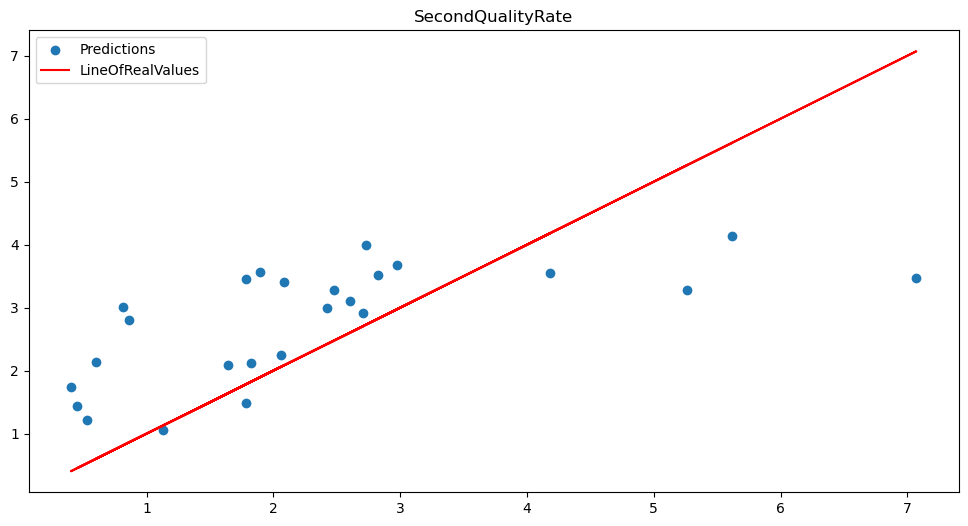

In [33]:
#Chart to show the closeness of the SecondQualityRate predictions to the true values is being plaotted
plt.figure(figsize = (12, 6))
plt.title('SecondQualityRate')
plt.scatter(testY, predictions)
plt.plot(testY, testY, 'r')
plt.legend(['Predictions', 'LineOfRealValues'])

In [34]:
#PredictedSecondQualityRate is being appended to testFrame
testFrame['PredictedSecondQualityRate'] = predictions / 100
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,SewingError,FabricStain,FabricError,EmbroideryError,MeasureError,SecondQuality,CalculatedSecondQuality,Defect,OrderQuantity,PredictedSecondQualityRate
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,15,5,2,0,2,25,26,32,420,0.041380
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,3,0,1,0,0,4,4,5,150,0.029976
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,26,2,3,0,0,123,124,143,4395,0.029102
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,3,1,0,0,0,4,4,5,200,0.014797
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0,0,0,5,0,5,5,7,170,0.031074
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,11,0,3,0,0,14,14,18,450,0.035217
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,10,0,2,0,0,11,12,18,250,0.035520
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,4,0,2,0,0,7,7,9,210,0.036819
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,1,0,0,0,0,4,4,10,190,0.035704
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,1,0,0,0,0,1,1,4,220,0.017397


In [35]:
#PredictedQuantity is being calculated according to OrderQuantity

#Equation Example
#OrderQuantity = PredictedQuantity - PredictedQuantity * PredictedSecondQualityRate
#OrderQuantity = PredictedQuantity * (1 - PredictedSecondQualityRate)
#PredictedQuantity = OrderQuantity / (1 - PredictedSecondQualityRate)

testFrame['PredictedQuantity'] = testFrame.apply(lambda row : 
                                                math.ceil(row['OrderQuantity'] / (1 - row['PredictedSecondQualityRate'])),
                                                axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,FabricStain,FabricError,EmbroideryError,MeasureError,SecondQuality,CalculatedSecondQuality,Defect,OrderQuantity,PredictedSecondQualityRate,PredictedQuantity
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,5,2,0,2,25,26,32,420,0.041380,439
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,0,1,0,0,4,4,5,150,0.029976,155
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,2,3,0,0,123,124,143,4395,0.029102,4527
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,1,0,0,0,4,4,5,200,0.014797,204
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0,0,5,0,5,5,7,170,0.031074,176
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,0,3,0,0,14,14,18,450,0.035217,467
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,0,2,0,0,11,12,18,250,0.035520,260
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,0,2,0,0,7,7,9,210,0.036819,219
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0,0,0,0,4,4,10,190,0.035704,198
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0,0,0,0,1,1,4,220,0.017397,224


In [36]:
#PredictedSecondQuality is being calculated

#Equation Example
#PredictedSecondQuality = PredictedQuantity - OrderQuantity

testFrame['PredictedSecondQuality'] = testFrame.apply(lambda row : 
                                                math.ceil(row['PredictedQuantity'] - row['OrderQuantity']), axis = 1)
testFrame

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,FabricError,EmbroideryError,MeasureError,SecondQuality,CalculatedSecondQuality,Defect,OrderQuantity,PredictedSecondQualityRate,PredictedQuantity,PredictedSecondQuality
0,-2.013910,1.995143,-1.926260,-1.974847,-0.470229,-0.920815,5.463404,-2.759364,2.244603,-0.119326,...,2,0,2,25,26,32,420,0.041380,439,19
1,0.081436,0.312799,-0.204645,4.329446,-0.406149,3.267323,2.083090,1.907919,0.579843,-0.524113,...,1,0,0,4,4,5,150,0.029976,155,5
2,-0.275271,3.378519,6.180660,-3.070387,-1.256094,2.695950,-1.440188,-1.783384,1.923091,-3.025943,...,3,0,0,123,124,143,4395,0.029102,4527,132
3,0.943398,-4.813578,0.824529,0.275050,0.786546,0.370814,0.870501,0.563257,-2.901741,-3.165466,...,0,0,0,4,4,5,200,0.014797,204,4
4,-0.379232,3.409618,-3.162239,2.686746,3.859326,0.532266,-1.527445,-1.047937,-1.601517,-0.551928,...,0,5,0,5,5,7,170,0.031074,176,6
5,-2.101637,2.223838,-1.556957,-2.129927,-0.512525,-0.824300,5.273366,-2.782388,2.460166,-0.430639,...,3,0,0,14,14,18,450,0.035217,467,17
6,-0.282043,3.811182,-2.230863,0.004519,2.087936,-1.753659,3.935391,0.919443,-1.236278,-0.553032,...,2,0,0,11,12,18,250,0.035520,260,10
7,-0.643040,0.346454,-0.315427,2.190501,-1.220767,2.136473,0.156331,-2.538222,-0.720663,1.731993,...,2,0,0,7,7,9,210,0.036819,219,9
8,12.352104,-1.044931,-5.463644,-0.329819,-2.043098,-0.491714,-0.910660,0.539819,3.024043,0.518843,...,0,0,0,4,4,10,190,0.035704,198,8
9,-2.104799,0.395125,-1.107901,-1.055992,-1.160363,-0.341301,-0.616943,-0.333464,0.484331,0.650698,...,0,0,0,1,1,4,220,0.017397,224,4


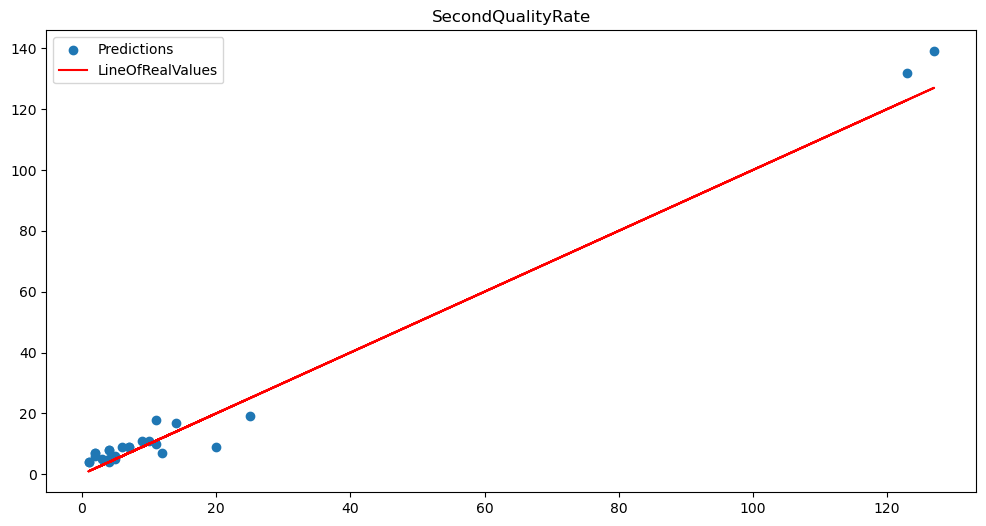

In [37]:
#Chart to show the closeness of the PredictedSecondQuality to the true values is being plaotted
plt.figure(figsize = (12, 6))
plt.title('SecondQualityRate')
plt.scatter(testFrame['SecondQuality'], testFrame['PredictedSecondQuality'])
plt.plot(testFrame['SecondQuality'], testFrame['SecondQuality'], 'r')
plt.legend(['Predictions', 'LineOfRealValues'])